In [1]:
import json
import logging
from typing import Annotated, TypedDict, List, Tuple

import pandas as pd
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# IPython display utilities
from IPython.display import Image

from utils import *
from prompts import *

# (1) Get segment name and description

In [2]:
INPUT_PATH = "gs://genai-explorer-bucket/data/cluster_info.csv"

In [3]:
segments_df = get_name_and_description(INPUT_PATH, prompt_template1, prompt_template2, verbose=True)
segments_df

<steps>
<step_1>
# Key Facts About Segment 1

1. Very low likelihood of playing fantasy sports (0.094) compared to overall population (0.445)
2. Very low likelihood of interest in football (0.076) compared to overall population (0.218)
3. Higher household income ($246,136.90) than overall average ($208,310.13)
4. Younger age (36.41 years) than overall average (43.97 years)
5. Lower spending on purchases ($223.51) than overall average ($267.12)
6. This segment represents 24% of the total population
</step_1>

<step_2>
# Segment Description

This segment consists of younger professionals in their mid-30s with above-average household incomes of around $246,000. Despite their financial prosperity, they spend less on purchases (about $223 per transaction) than the average consumer. They show remarkably little interest in sports, particularly having minimal engagement with fantasy sports and football compared to the general population. This affluent group appears to allocate their resources 

,segment_id,segment_name,segment_description,segment_share_in_percent
0,1,Affluent Career-Focused Millennials,This segment consists of younger professionals...,24
1,2,Financially Bold Seniors,This segment consists of financially adventuro...,31
2,3,Premium Conservative Spenders,This segment consists of high-value but infreq...,32
3,4,Affluent Sports Enthusiasts,This segment consists of avid sports enthusias...,13


In [5]:
s = segments_df.to_json()

In [8]:
pd.DataFrame(json.loads(s))

,segment_id,segment_name,segment_description,segment_share_in_percent
0,1,Affluent Career-Focused Millennials,This segment consists of younger professionals...,24
1,2,Financially Bold Seniors,This segment consists of financially adventuro...,31
2,3,Premium Conservative Spenders,This segment consists of high-value but infreq...,32
3,4,Affluent Sports Enthusiasts,This segment consists of avid sports enthusias...,13


# (2) Find images for segments

In [7]:
num_segments = 4
new_filetype = "png"

In [8]:
segments_df["segment_id"] = segments_df["segment_id"].astype(int)

In [9]:
for segment_id in range(1, num_segments + 1):
    search_query = segments_df[segments_df["segment_id"] == segment_id].iloc[0]["segment_name"] + " with people"
    print(search_query)
    images = search_google_images_selenium(search_query, num_images=15)
    image_filetype, image_base64 = find_the_best_image(images, search_query, prompt_template=prompt_template3)
    filename=f"best_image{segment_id}"
    filename = save_base64_image_to_file(image_base64, filename=filename, filetype=image_filetype, new_size=140, new_filetype=new_filetype)
    print(filename)

Affluent Career-Focused Millennials with people

You are an assistant to an analyst who is creating a presentation material.
Here we are trying to find the best image for the given description.

<description>
Affluent Career-Focused Millennials with people
</description>

<guidelines>
1. The best image has to have people's happy faces in it.
2. The best image  has to be a photographed image.
3. The best image does not contain texts in the image.
4. Do not pick one with multiple photographs in one image.
5. Do not pick an inappropriate image because the image will be used in a presentation.
6. Your response should be just one integer. For example, if the 3rd image out of 10 images is picked, the response should be just "3".
</guidelines>

best_image1.png
Risk-Embracing Active Seniors with people

You are an assistant to an analyst who is creating a presentation material.
Here we are trying to find the best image for the given description.

<description>
Risk-Embracing Active Seniors wit

# (3) Generate the slide

In [10]:
final_pptx = generate_slide(segments_df,
    num_segments=num_segments,
    template_pptx_prefix="gs://genai-explorer-bucket/templates",
    image_type= new_filetype,
    final_pptx = "gs://genai-explorer-bucket/temp/segments5.pptx"
)
final_pptx

# (4) Create langgraph workflow

In [2]:
INPUT_PATH = "gs://genai-explorer-bucket/data/cluster_info.csv"
TEMPLATE_PPTX_PREFIX = "gs://genai-explorer-bucket/templates"
FINAL_PPTX = "gs://genai-explorer-bucket/temp/segments.pptx"

In [41]:
# Define the agent's state
class AgentState(TypedDict):
    input_path: str
    template_pptx_prefix: str
    final_pptx_filename: str
    num_segments: int
    segments_df_str: str
    search_queries: list
    messages: Annotated[list, add_messages]

input_state = {
    "input_path": INPUT_PATH,
    "template_pptx_prefix": TEMPLATE_PPTX_PREFIX,
    "final_pptx_filename": FINAL_PPTX,
    "messages": [
        SystemMessage(content=prompt_template4_system),
    ],
}
# Initialize agent memory
memory = MemorySaver()

In [42]:
def get_names_and_descriptions(state: AgentState):
    print("* starting get_names_and_description")
    input_path = state["input_path"]
    segments_df = get_name_and_description(input_path, prompt_template1, prompt_template2, verbose=False)
    num_segments = segments_df["segment_id"].nunique()
    return {
        "segments_df_str": segments_df.to_json(),
        "num_segments": num_segments,
    }

In [43]:
def get_search_queries_for_images(state: AgentState):
    print("* starting get_search_queries_for_images")
    segments_df = pd.DataFrame(json.loads(state["segments_df_str"]))
    segments_df["segment_id"] = segments_df["segment_id"].astype(int)
    search_queries = []
    for segment_id in sorted(segments_df["segment_id"].unique()):
        search_query = segments_df[segments_df["segment_id"] == segment_id].iloc[0]["segment_name"] + " with people"
        search_queries.append({"id": int(segment_id), "search_query": search_query})
    return {
        "search_queries": search_queries,
        "messages": [HumanMessage(content=prompt_template4_user.format(search_queries=json.dumps(search_queries)))]
    }

In [44]:
@tool
def find_and_save_image_for_segment(
    segment_id: str,
    search_query: str,
) -> str:
    """
    Search images in Google Images using the given search query, and retrieve those images.
    
    Args:
        segment_id (str): id of the segment
        search_query (str): The search term or description
        
    Returns:
        filename of the saved image
    """
    print(f"* starting find_and_save_image_for_segment for segment_id {segment_id}")
    images = search_google_images_selenium(search_query, num_images=15)
    image_filetype, image_base64 = find_the_best_image(images, search_query, prompt_template=prompt_template3)
    filename=f"best_image{segment_id}"
    filename = save_base64_image_to_file(image_base64, filename=filename, filetype=image_filetype, new_size=140)
    return filename

In [45]:
tools = [find_and_save_image_for_segment]
tool_node = ToolNode(tools)

In [46]:
def get_images(state: AgentState):
    print("* starting get_images")
    messages = state["messages"]
    last_message = messages[-1]
    model_with_tools = MODEL_LANGCHAIN.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    return {
        "messages": [response]
    }

In [47]:
# Determine if additional tool calls are needed
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "find_and_save_image_tool"
    return "create_slide"

In [56]:
def create_slide(state: AgentState):
    print("* starting create_slide")
    segments_df = pd.DataFrame(json.loads(state["segments_df_str"]))
    segments_df["segment_id"] = segments_df["segment_id"].astype(int)
    num_segments = state["num_segments"]
    template_pptx_prefix = state["template_pptx_prefix"]
    final_pptx = state["final_pptx_filename"]
    try:
        _ = generate_slide(segments_df,
            num_segments=num_segments,
            template_pptx_prefix=template_pptx_prefix,
            final_pptx=final_pptx
        )
        return {"messages": f"{final_pptx} has been created."}
    except Exception as e:
        return {"messages": str(e)}

## (4-1) Define the workflow

In [57]:
# Initialize the LangGraph workflow, specifying the agent's state schema
workflow = StateGraph(AgentState)

# Add nodes to the workflow, associating each node with its corresponding function
workflow.add_node("get_names_and_descriptions", get_names_and_descriptions)
workflow.add_node("get_search_queries_for_images", get_search_queries_for_images)
workflow.add_node("get_images", get_images)
workflow.add_node("find_and_save_image_tool", tool_node)
workflow.add_node("create_slide", create_slide)

# Define the flow of execution between nodes, creating the workflow's logic
workflow.add_edge(START, "get_names_and_descriptions")
workflow.add_edge("get_names_and_descriptions", "get_search_queries_for_images")
workflow.add_edge("get_search_queries_for_images", "get_images")
workflow.add_conditional_edges("get_images", should_continue, ["find_and_save_image_tool", "create_slide"])
workflow.add_edge("find_and_save_image_tool", "get_images")
workflow.add_edge("create_slide", END)

In [58]:
# Compile the LangGraph workflow, enabling memory-based state management
graph = workflow.compile(checkpointer=memory)

## (4-2) Execute the workflow

In [59]:
# Initialize a LangGraph thread with a unique ID for state management.
thread_config = {"configurable": {"thread_id": "1"}}
stream_mode = "updates"  # "updates" (only updates) or "values" (all values)

# Execute the LangGraph workflow, streaming the results of each node.
for state in graph.stream(
    input=input_state,
    config=thread_config,
    stream_mode=stream_mode,
):
    # Print the name of the current node and its output for each step.
    for node_name, node_output in state.items():
        print(f"Agent Node: {node_name}\n")
        print("Agent Result:")
        print(str(node_output))  # Truncate output for display
        #print("\n-------------------\n")
    print("\n====================\n")

* starting get_names_and_description
Agent Node: get_names_and_descriptions

Agent Result:
{'segments_df_str': '{"segment_id":{"0":1,"1":2,"2":3,"3":4},"segment_name":{"0":"Affluent Career-Focused Millennials","1":"Risk-Taking Active Seniors","2":"Premium Conservative Spenders","3":"Affluent Sports Enthusiasts"},"segment_description":{"0":"This segment consists of younger professionals in their mid-30s with above-average household incomes of around $246,000. Despite their financial prosperity, they spend less on purchases (about $224 per transaction) than the average consumer. Notably, these individuals show minimal interest in sports, with particularly low engagement in fantasy sports and football compared to the general population. They represent nearly a quarter of the customer base.","1":"This segment consists of financially risk-tolerant seniors in their early 60s who are active consumers despite having moderate incomes. With an average household income of $135,000 (lower than the

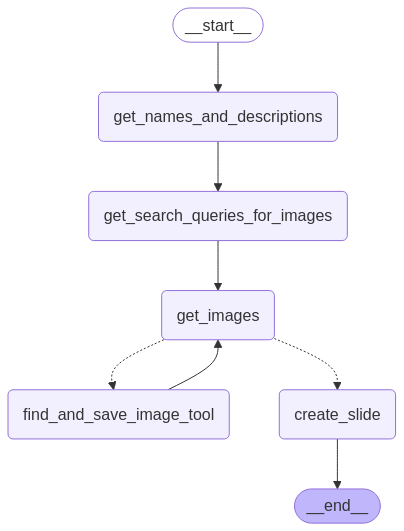

In [63]:
graph